In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc

CPU times: user 1.45 s, sys: 1.05 s, total: 2.51 s
Wall time: 1.77 s


In [2]:
%%time
df = pd.read_csv("train.csv", low_memory = False)

CPU times: user 21.2 ms, sys: 10.5 ms, total: 31.7 ms
Wall time: 31.6 ms


In [3]:
%%time
df = add_datepart(df, 'date')

CPU times: user 77.4 ms, sys: 622 µs, total: 78 ms
Wall time: 74.4 ms


In [4]:
df["num_sold"].min(), df["num_sold"].max()

(70, 2884)

In [5]:
df.head()

,row_id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,Finland,KaggleMart,Kaggle Mug,329,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
1,1,Finland,KaggleMart,Kaggle Hat,520,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
2,2,Finland,KaggleMart,Kaggle Sticker,146,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
3,3,Finland,KaggleRama,Kaggle Mug,572,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
4,4,Finland,KaggleRama,Kaggle Hat,911,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09


In [6]:
cond = (df.Year < 2018)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [7]:
splits = (list(train_idx), list(valid_idx))
dep_var = "num_sold"
cont, cat = cont_cat_split(df, 1, dep_var)

In [8]:
cont

['row_id', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Elapsed']

In [9]:
cont.remove("row_id")

In [10]:
procs = [Categorify, FillMissing]
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [11]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [12]:
def calculate_smape(m, valid_xs, valid_y):
    preds = list(m.predict(valid_xs))
    total = len(preds)
    smape = 0
    for i,j in zip(preds, valid_y) :
        diff = np.abs(i - j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smape += fin
        
    smape = (smape/total) * 100 
    
    return smape

In [13]:
len(xs)

19728

In [14]:
len(xs)//2

9864

In [15]:
def rf(xs, y, n_estimators = 40, max_samples = 9800, max_features = 0.5, min_samples_leaf = 5, **kwargs):
    return RandomForestRegressor(n_estimators = n_estimators, n_jobs = -1, max_features = max_features, max_samples = max_samples,
                                 min_samples_leaf = min_samples_leaf, oob_score = True).fit(xs, y)

In [16]:
%%time
m = rf(xs, y)

CPU times: user 1.16 s, sys: 1.17 ms, total: 1.17 s
Wall time: 319 ms


In [17]:
calculate_smape(m, xs, y)

4.970420398497426

In [18]:
calculate_smape(m, valid_xs, valid_y)

10.292981498394445

In [19]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols' : df.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)

In [20]:
fi = rf_feat_importance(m, xs)

In [21]:
fi[:10]

,cols,imp
2,product,0.527093
1,store,0.185489
0,country,0.121850
14,Dayofyear,0.068528
13,Dayofweek,0.029477
11,Week,0.028993
10,Month,0.019244
15,Elapsed,0.011882
12,Day,0.004781
9,Year,0.001786


In [22]:
fi

,cols,imp
2,product,0.527093
1,store,0.185489
0,country,0.121850
14,Dayofyear,0.068528
13,Dayofweek,0.029477
11,Week,0.028993
10,Month,0.019244
15,Elapsed,0.011882
12,Day,0.004781
9,Year,0.001786


In [23]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize = (12, 7), legend = False)

<AxesSubplot:ylabel='cols'>

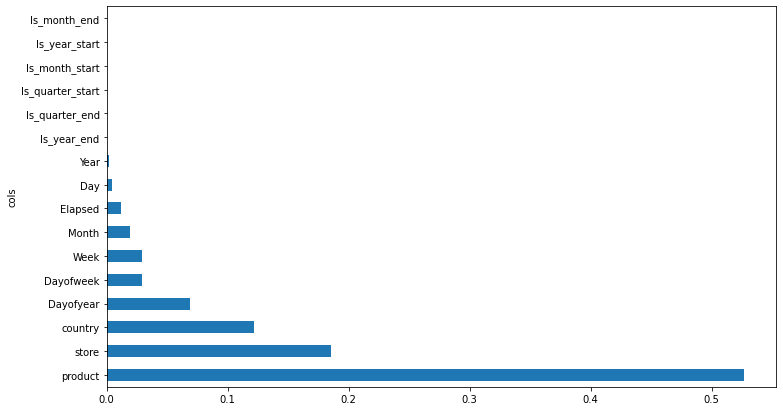

In [24]:
plot_fi(fi)

In [25]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

8

In [26]:
%%time
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

CPU times: user 942 ms, sys: 25.8 ms, total: 967 ms
Wall time: 275 ms


In [27]:
calculate_smape(m, xs_imp, y)

5.091324518726262

In [28]:
calculate_smape(m, valid_xs_imp, y)

20.884274691190623

In [29]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

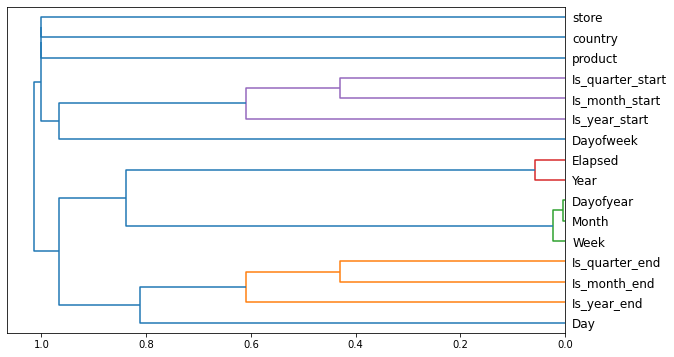

In [30]:
cluster_columns(xs)

([<matplotlib.axis.YTick at 0x7f89049c5d30>,
 [Text(0, 0, 'Kaggle Hat'),
  Text(0, 1, 'Kaggle Mug'),
  Text(0, 2, 'Kaggle Sticker')])

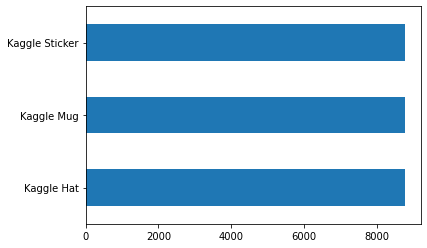

In [42]:
p = df["product"].value_counts(sort = False).plot.barh()
c = to.classes["product"]
c = c[1:]
plt.yticks(range(len(c)), c)

In [43]:
to.items.head()

,row_id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,1,1,2,329,2015,1,1,1,3,1,1,2,1,2,1,2,1.420070e+09
1,1,1,1,1,520,2015,1,1,1,3,1,1,2,1,2,1,2,1.420070e+09
2,2,1,1,3,146,2015,1,1,1,3,1,1,2,1,2,1,2,1.420070e+09
3,3,1,2,2,572,2015,1,1,1,3,1,1,2,1,2,1,2,1.420070e+09
4,4,1,2,1,911,2015,1,1,1,3,1,1,2,1,2,1,2,1.420070e+09


([<matplotlib.axis.YTick at 0x7f89044e9760>,
 [Text(0, 0, '#na#'), Text(0, 1, 'KaggleMart'), Text(0, 2, 'KaggleRama')])

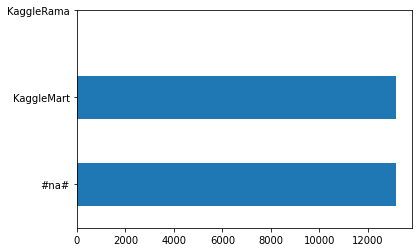

In [54]:
p = df["store"].value_counts(sort = False).plot.barh()
c = to.classes["store"]
#c = c[1:]
plt.yticks(range(len(c)), c)

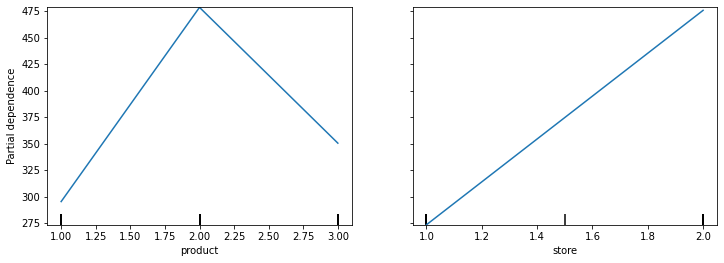

In [51]:
fig, ax = plt.subplots(figsize = (12, 4))
plot_partial_dependence(m, valid_xs, ['product', 'store'], 
                        grid_resolution = 20, ax = ax)

In [55]:
to.classes["store"]

['#na#', 'KaggleMart', 'KaggleRama']

In [58]:
df[df.store == 'KaggleRama']["num_sold"].mean(), df[df.store == 'KaggleMart']["num_sold"].mean()

(492.50817552665603, 282.5589778690395)

In [64]:
m = rf(xs_imp, y)
print ("Orig: {}".format(calculate_smape(m, valid_xs_imp, valid_y)))

for c in ["Elapsed"] :
    m = rf(xs_imp.drop(c, axis = 1), y)
    print (c, calculate_smape(m, valid_xs_imp.drop(c, axis = 1), valid_y))

Orig: 8.65325930822274
Elapsed 12.2131991183084


In [65]:
df["product"].unique()

array(['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker'], dtype=object)

In [78]:
df[df['product'] == "Kaggle Mug"]["num_sold"].mean(), df[df["product"] == "Kaggle Hat"]["num_sold"].mean(), df[df["product"] == "Kaggle Sticker"]["num_sold"].mean()

(354.35626283367554, 628.84610997034, 179.39835728952772)

In [79]:
c = to.classes["product"]

In [80]:
c

['#na#', 'Kaggle Hat', 'Kaggle Mug', 'Kaggle Sticker']

In [127]:
df_nn = pd.read_csv("train.csv", low_memory = False)
df_nn['product'] = df_nn['product'].astype('category')
sizes = 'Kaggle Sticker', 'Kaggle Mug', 'Kaggle Hat'
df_nn['product'].cat.set_categories(sizes, ordered = True, inplace = True)
sizes = 'KaggleRama', 'KaggleMart'
df_nn['store'] = df_nn['store'].astype('category')
df_nn['store'].cat.set_categories(sizes, ordered = True, inplace = True)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [128]:
df_nn = add_datepart(df_nn, 'date')

In [129]:
df_nn_final = df_nn[list(xs_imp.columns) + [dep_var]]

In [130]:
df_nn_final.head()

,product,store,country,Dayofyear,Dayofweek,Week,Month,Elapsed,num_sold
0,Kaggle Mug,KaggleMart,Finland,1,3,1,1,1.420070e+09,329
1,Kaggle Hat,KaggleMart,Finland,1,3,1,1,1.420070e+09,520
2,Kaggle Sticker,KaggleMart,Finland,1,3,1,1,1.420070e+09,146
3,Kaggle Mug,KaggleRama,Finland,1,3,1,1,1.420070e+09,572
4,Kaggle Hat,KaggleRama,Finland,1,3,1,1,1.420070e+09,911


In [131]:
df_nn_final.head(3)

,product,store,country,Dayofyear,Dayofweek,Week,Month,Elapsed,num_sold
0,Kaggle Mug,KaggleMart,Finland,1,3,1,1,1.420070e+09,329
1,Kaggle Hat,KaggleMart,Finland,1,3,1,1,1.420070e+09,520
2,Kaggle Sticker,KaggleMart,Finland,1,3,1,1,1.420070e+09,146


In [132]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card = 9000, dep_var = dep_var)

In [133]:
cont_nn

['Elapsed']

In [134]:
cat_nn

['product', 'store', 'country', 'Dayofyear', 'Dayofweek', 'Week', 'Month']

In [135]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs, cat_nn, cont_nn, y_names = dep_var, splits = splits)

In [136]:
to_nn.items.head()

,product,store,country,Dayofyear,Dayofweek,Week,Month,Elapsed,num_sold
0,2,2,1,1,4,1,1,1.420070e+09,329
1,3,2,1,1,4,1,1,1.420070e+09,520
2,1,2,1,1,4,1,1,1.420070e+09,146
3,2,1,1,1,4,1,1,1.420070e+09,572
4,3,1,1,1,4,1,1,1.420070e+09,911


In [137]:
to_nn.classes["product"]

['#na#', 'Kaggle Sticker', 'Kaggle Mug', 'Kaggle Hat']

In [138]:
to_nn.classes["store"]

['#na#', 'KaggleRama', 'KaggleMart']

In [139]:
dls = to_nn.dataloaders(1024, device = "cuda")

In [140]:
y = to_nn.train.y

In [141]:
y.min(), y.max()

(70, 2807)

In [142]:
y.dtype

dtype('int16')

In [155]:
learn = tabular_learner(dls, y_range = (69, 2808), n_out = 1, layers = [500, 250])

CPU times: user 1.21 s, sys: 48.3 ms, total: 1.26 s
Wall time: 1.23 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0014454397605732083)

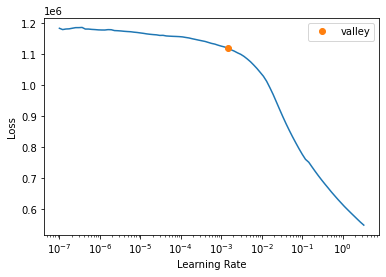

In [156]:
%%time
learn.lr_find()

In [157]:
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,time
0,781920.062500,4571265.000000,00:00
1,366263.531250,204893.906250,00:00
2,257266.406250,212083.609375,00:00
3,217395.453125,212258.562500,00:00
4,195833.453125,212258.546875,00:00
5,182704.656250,212258.343750,00:00
6,174758.234375,212258.171875,00:00
7,169332.203125,212258.062500,00:00
8,166014.609375,212258.031250,00:00
9,163673.046875,212258.000000,00:00


In [158]:
preds, targs = learn.get_preds()

In [159]:
def smape(preds, targs):
    smp = 0
    total = len(preds)
    for i,j in zip(preds, targs):
        diff = np.abs(i-j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smp += fin
        
    smp = (smp/total) * 100 
    
    return smp

In [160]:
smape(preds, targs)

tensor([126.0172])